In [3]:
using LinearAlgebra
using Plots

In [4]:
pyplot()

Plots.PyPlotBackend()

In [758]:
function initgrid(L0,h,N)
    X = [ -L0 + h*(i-1) for i=1:N+1]
    0.5(X[1:N]+X[2:N+1])
end
function sol1(X)
    1. - 0.5(X.^2 + X)
end
function sol2(X)
    n = length(X)
    a = cos.(pi*(X+0.5(ones(n)))).^5
    b = zeros(n)
    out = mymax(b,a)
end
function sol3(X)
    out = Array{Float64,1}(undef,0)
    for i = 1:length(X)
    (X[i] > -0.75) && (X[i] < -0.25) ? push!(out,1) : push!(out,0)
    end
    out
end
function mymax(X::AbstractVector{T},Y::AbstractVector{T}) where {T<:Number}
    out = Array{Float64,1}(undef,0)
    for i = 1:length(X)
    X[i] > Y[i] ? push!(out,X[i]) : push!(out,Y[i])
    end
    out
end
function rc(a::T,b::T) where {T<:Number}
    0.5(a + b)
end
function a_in(a::T) where {T<:Number}
    a > 0 ? a : 0
end
function a_ou(a::T) where {T<:Number}
    a < 0 ? a : 0
end
function BCs(X,v,j,tau,case)
    if case == 1
        ana = sol1.(X - v*tau*j);
    elseif case == 2
        ana = sol2(X - v*tau*j);
    elseif case == 3
        ana = sol3(X - v*tau*j);
    end
    bcl = ana[1]
    bcr = ana[end]
    bcl, bcr
end
function coeff_out(v,i)
    C = a_ou(rc(v[i],v[i-1]))
    E = a_ou(-rc(v[i],v[i+1]))
    C, E
end
function coeff_in(v,i)
    A = a_in(rc(v[i],v[i-1]))
    B = a_in(-rc(v[i],v[i+1]))
    A, B
end
function solvertri(dl::V, d::V, du::V, b::V) where V <: AbstractVector
    Mat = Tridiagonal(dl, d, du)
    #println(Mat)
    x = Mat\b
end
function initialisation(N,h,L0,case)
    X = initgrid(L0,h,N);
    if case == 1
        u = sol1.(X)
        u1 = sol1.(X)
    elseif case == 2
        u = sol2(X)
        u1 = sol2(X)
    elseif case == 3
        u = sol3(X)
        u1 = sol3(X)
    end
    up = zeros(N);
    upp = zeros(N);
    tin = zeros(N);
    X, u, up, upp, u1, tin
end
function err1(err,X,u,v,tau,nt,h,case)
    if case == 1
        ua = sol1.(X - v*tau*nt);
    elseif case == 2
        ua = sol2(X - v*tau*nt);
    elseif case == 3
        ua = sol3(X - v*tau*nt);
    end
    for i = 1:length(u)
        err += abs(ua[i] - u[i])*h
    end
    X, u, ua, err
end
function S1IIOE(a,Tmax,L0,vit,dh,case)
    err = 0.0
    N = a
    h = 2*L0/N
    v = vit*ones(N)
    tau = dh*h
    nt = trunc(Int, Tmax/tau)
    X, u, up, upp, u1, tin = initialisation(N,h,L0,case)
    for j = 1:nt
        up, tin = outflow(X,v,tau,h,u,up,j,tin,case)
        #upp = quadratic(upp,up)
        u = inflow(up,v,tau,h,tin)
        u = restore0(u)
    end
    ua = sol1.(X - v*tau*nt);
    X, u, ua, err = err1(err,X,u,v,tau,nt,h,case);
    X, u, ua, err, u1, tin
end
    
function outflow(X,v,tau,h,u,up,j,tin,case)
    bcl, bcr = BCs(X,v,j,tau,case)
    for i = 2:(length(u)-1)
        m = tau/h
        C, E = coeff_out(v,i)
        tout, tin[i] = findtheta(u,tau,h,E,i)
        #tout = 0.5
        #tin[i] = 0.5
        up[i] = m*C*u[i-1] + (1.0 - m*C - m*tout*E)*u[i] + m*tout*E*u[i+1]
        if abs(u[i]) < 1e-100
            u[i] = 0.0
        end
    end
    up[1] = bcl
    up[end] = bcr
    up, tin
end
function inflow(up,v,tau,h,tin)   
    dl = Array{Float64,1}(undef,0);
    d = Array{Float64,1}(undef,0);
    du = Array{Float64,1}(undef,0);
    push!(d, 1.0)
    push!(du, 0.0)
    for i = 2:(length(up)-1)
        m = tau/h
        A, B = coeff_in(v,i)
        push!(dl, m*tin[i]*(-A))
        push!(d, (1.0 + m*tin[i]*A + m*B))
        push!(du, m*(-B))
    end
    push!(dl, 0.0)
    push!(d, 1.0)
    solvertri(dl, d, du, up)
end
function findtheta(u,tau,h,E,i)
    if E*(u[i+1] - u[i]) > 0
        umax = max(u[i-1],u[i],u[i+1])
        tout = min(0.5,((h*(umax - u[i]))/(tau*E*(u[i+1] - u[i]))))
        tin = 1.0 - tout
        #println("max ",i," ",tout," ",tin," ", E, " ", ((h*(umax - u[i]))/(-tau*E*(u[i+1] - u[i]))))
    elseif E*(u[i+1] - u[i]) < 0
        umin = min(u[i-1],u[i],u[i+1])
        tout = min(0.5,((h*(umin - u[i]))/(tau*E*(u[i+1] - u[i]))))
        tin = 1.0 - tout
        #println("min ",i," ",tout," ",tin," ", E, " ", ((h*(umin - u[i]))/(-tau*E*(u[i+1] - u[i]))))
    elseif abs(E*(u[i+1] - u[i])) == 0.0
        tout = 0.5
        tin = 1.0 - tout
    end
    #tout = 0.5;
    tout, tin
end
function quadratic(upp,u)
    for i = 2:length(upp)-1
        upp[i] = (1/6)*u[i-1] + (2/3)*u[i] + (1/6)*u[i+1]
    end
    upp
end
function restore0(u)
    for i = 1:length(u)
        if (abs(u[i]) < 1e-200)
            #println(i)
            u[i] = 0.0
        end
    end
    u
end

restore0 (generic function with 1 method)

##### Parameters

In [759]:
N = 1280
case = 3
dh = 1;


In [760]:
X, u, ua, err, u1, tin = S1IIOE(N,1.0,1.0,1.0,dh,case); #(N,Tmax,L0,vit,dh,case)

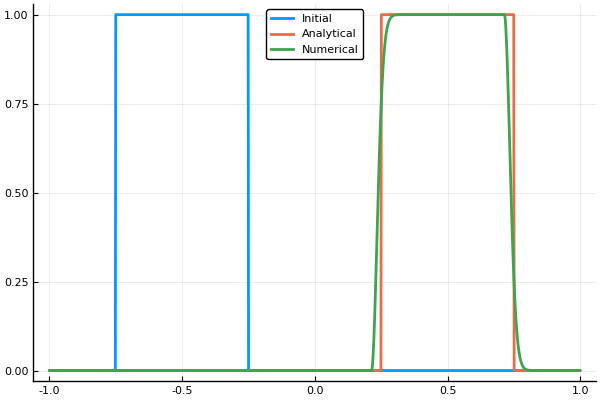

In [761]:
plot(X,[u1,ua,u],label = ["Initial" "Analytical" "Numerical"], lw = 2)

In [762]:
err

0.029844801829078303